In [2]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [4]:
pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [5]:
import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.applications import ResNet50V2,ResNet101V2,ResNet152V2,DenseNet201
print("Tensorflow version " + tf.__version__)

2024-07-17 20:59:23.923282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 20:59:23.923392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 20:59:24.069963: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version 2.15.0


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import models, layers

In [7]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [8]:
IMAGE_SIZE = 512
EPOCHS = 10
CHANNELS = 3
BATCH_SIZE = 16 

In [9]:
tf.keras.backend.clear_session()
import gc
gc.collect()

0

In [10]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/leaf-disease-machvis/dataset/train",
  shuffle=True,
  image_size=(IMAGE_SIZE,IMAGE_SIZE),
  batch_size=BATCH_SIZE
)

Found 72339 files belonging to 63 classes.


In [12]:
class_names= dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cassava__bacterial_blight',
 'Cassava__brown_streak_disease',
 'Cassava__green_mottle',
 'Cassava__healthy',
 'Cassava__mosaic_disease',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Cherry__powdery_mildew',
 'Chili__healthy',
 'Chili__leaf curl',
 'Chili__leaf spot',
 'Chili__whitefly',
 'Chili__yellowish',
 'Coffee__cercospora_leaf_spot',
 'Coffee__healthy',
 'Coffee__red_spider_mite',
 'Coffee__rust',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Cucumber__diseased',
 'Cucumber__healthy',
 'Gauva__diseased',
 'Gauva__healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 

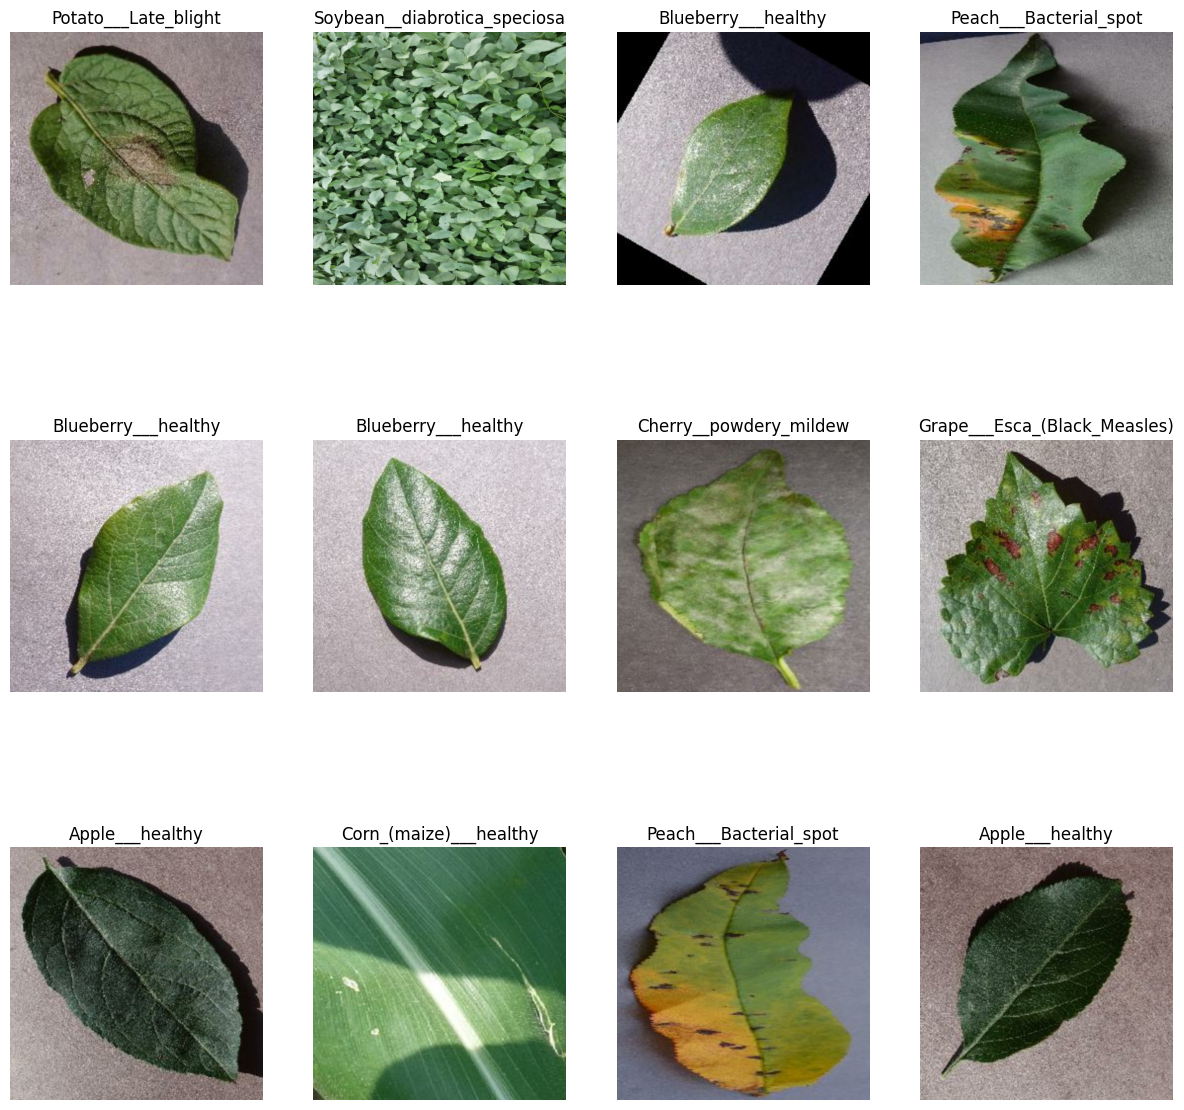

In [13]:
plt.figure(figsize=(15,15))
for image_batch,labels_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.9, val_split=0.1, shuffle=True, shuffle_size=300):
    assert (train_split  + val_split) == 1
    ds_size = tf.data.experimental.cardinality(ds).numpy()

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)


    return train_ds, val_ds

# Partition the dataset
train_ds, val_ds = get_dataset_partitions_tf(dataset)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/leaf-disease-machvis/dataset/test",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names

Found 20121 files belonging to 67 classes.


In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [16]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

Physical devices cannot be modified after being initialized


In [23]:

num_classes = len(class_names)
if num_classes < 1:
    raise ValueError("The class names list is empty. Please define your class names correctly.")


In [25]:
import math
import re
import os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.applications import ResNet50V2, ResNet101V2, ResNet152V2, DenseNet201

print("Tensorflow version " + tf.__version__)  # Ensure this is 2.x

# Load the DenseNet201 model without the top classification layer
rnet = DenseNet201(
    input_shape=(512, 512, 3),
    weights='imagenet',
    include_top=False
)

# Create the model and add new layers
model = tf.keras.Sequential([
    rnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)


Tensorflow version 2.15.0


In [20]:
import tensorflow as tf
print(tf.__version__)  # Ensure this is 2.x


2.15.0


In [26]:
def lrfn(epoch):
    LR_START = 0.00001
    LR_MAX = 0.00005 
    LR_MIN = 0.00001
    LR_RAMPUP_EPOCHS = 5
    LR_SUSTAIN_EPOCHS = 0
    LR_EXP_DECAY = .8
    
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

In [27]:
def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [28]:
NUM_TRAINING_IMAGES = len(train_ds)
NUM_VALIDATION_IMAGES = len(val_ds)
STEPS_PER_EPOCH = (NUM_TRAINING_IMAGES + NUM_VALIDATION_IMAGES) // BATCH_SIZE

print('Dataset: {} training images, {} validation images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES))

Dataset: 4069 training images, 452 validation images


In [30]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

history = model.fit(
    train_ds, 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS, 
    callbacks=[lr_schedule]
)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/10


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
2024-07-17 21:16:26.884902: E external/local_xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module a_inference_one_step_on_data_170214__.89107] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-07-17 21:16:45.171222: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m18.286441406s

********************

 69/282 ━━━━━━━━━━━━━━━━━━━━ 4:10 1s/step - loss: 4.0123 - sparse_categorical_accuracy: 0.0606

Invalid SOS parameters for sequential JPEG


112/282 ━━━━━━━━━━━━━━━━━━━━ 3:19 1s/step - loss: 3.8986 - sparse_categorical_accuracy: 0.0853

Invalid SOS parameters for sequential JPEG


153/282 ━━━━━━━━━━━━━━━━━━━━ 2:31 1s/step - loss: 3.7917 - sparse_categorical_accuracy: 0.1172

Invalid SOS parameters for sequential JPEG


192/282 ━━━━━━━━━━━━━━━━━━━━ 1:45 1s/step - loss: 3.7002 - sparse_categorical_accuracy: 0.1464

Invalid SOS parameters for sequential JPEG


210/282 ━━━━━━━━━━━━━━━━━━━━ 1:24 1s/step - loss: 3.6599 - sparse_categorical_accuracy: 0.1598

Invalid SOS parameters for sequential JPEG


221/282 ━━━━━━━━━━━━━━━━━━━━ 1:11 1s/step - loss: 3.6356 - sparse_categorical_accuracy: 0.1680

Invalid SOS parameters for sequential JPEG


262/282 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 3.5466 - sparse_categorical_accuracy: 0.1979

Invalid SOS parameters for sequential JPEG


264/282 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 3.5423 - sparse_categorical_accuracy: 0.1993

Invalid SOS parameters for sequential JPEG


282/282 ━━━━━━━━━━━━━━━━━━━━ 788s 1s/step - loss: 3.5019 - sparse_categorical_accuracy: 0.2125 - learning_rate: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.8000000000000004e-05.
Epoch 2/10
 42/282 ━━━━━━━━━━━━━━━━━━━━ 4:41 1s/step - loss: 1.8471 - sparse_categorical_accuracy: 0.6947

Invalid SOS parameters for sequential JPEG


 49/282 ━━━━━━━━━━━━━━━━━━━━ 4:33 1s/step - loss: 1.8241 - sparse_categorical_accuracy: 0.7008

Invalid SOS parameters for sequential JPEG


 51/282 ━━━━━━━━━━━━━━━━━━━━ 4:30 1s/step - loss: 1.8178 - sparse_categorical_accuracy: 0.7025

Invalid SOS parameters for sequential JPEG


 90/282 ━━━━━━━━━━━━━━━━━━━━ 3:45 1s/step - loss: 1.7181 - sparse_categorical_accuracy: 0.7275

Invalid SOS parameters for sequential JPEG


 94/282 ━━━━━━━━━━━━━━━━━━━━ 3:40 1s/step - loss: 1.7104 - sparse_categorical_accuracy: 0.7291

Invalid SOS parameters for sequential JPEG


 95/282 ━━━━━━━━━━━━━━━━━━━━ 3:39 1s/step - loss: 1.7085 - sparse_categorical_accuracy: 0.7295

Invalid SOS parameters for sequential JPEG


109/282 ━━━━━━━━━━━━━━━━━━━━ 3:22 1s/step - loss: 1.6830 - sparse_categorical_accuracy: 0.7341

Invalid SOS parameters for sequential JPEG


110/282 ━━━━━━━━━━━━━━━━━━━━ 3:21 1s/step - loss: 1.6813 - sparse_categorical_accuracy: 0.7345

Invalid SOS parameters for sequential JPEG


159/282 ━━━━━━━━━━━━━━━━━━━━ 2:24 1s/step - loss: 1.6024 - sparse_categorical_accuracy: 0.7464

Invalid SOS parameters for sequential JPEG


197/282 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - loss: 1.5506 - sparse_categorical_accuracy: 0.7535

Invalid SOS parameters for sequential JPEG


219/282 ━━━━━━━━━━━━━━━━━━━━ 1:13 1s/step - loss: 1.5232 - sparse_categorical_accuracy: 0.7572

Invalid SOS parameters for sequential JPEG


234/282 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - loss: 1.5056 - sparse_categorical_accuracy: 0.7595

Invalid SOS parameters for sequential JPEG


250/282 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - loss: 1.4876 - sparse_categorical_accuracy: 0.7617

Invalid SOS parameters for sequential JPEG


269/282 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 1.4675 - sparse_categorical_accuracy: 0.7641

Invalid SOS parameters for sequential JPEG


282/282 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - loss: 1.4533 - sparse_categorical_accuracy: 0.7658 - learning_rate: 1.8000e-05

Epoch 3: LearningRateScheduler setting learning rate to 2.6000000000000002e-05.
Epoch 3/10
 44/282 ━━━━━━━━━━━━━━━━━━━━ 4:38 1s/step - loss: 0.7504 - sparse_categorical_accuracy: 0.8280

Invalid SOS parameters for sequential JPEG


 62/282 ━━━━━━━━━━━━━━━━━━━━ 4:17 1s/step - loss: 0.7382 - sparse_categorical_accuracy: 0.8332

Invalid SOS parameters for sequential JPEG


 69/282 ━━━━━━━━━━━━━━━━━━━━ 4:09 1s/step - loss: 0.7348 - sparse_categorical_accuracy: 0.8348

Invalid SOS parameters for sequential JPEG


 98/282 ━━━━━━━━━━━━━━━━━━━━ 3:35 1s/step - loss: 0.7241 - sparse_categorical_accuracy: 0.8388

Invalid SOS parameters for sequential JPEG


149/282 ━━━━━━━━━━━━━━━━━━━━ 2:35 1s/step - loss: 0.7065 - sparse_categorical_accuracy: 0.8437

Invalid SOS parameters for sequential JPEG


157/282 ━━━━━━━━━━━━━━━━━━━━ 2:26 1s/step - loss: 0.7038 - sparse_categorical_accuracy: 0.8442

Invalid SOS parameters for sequential JPEG


165/282 ━━━━━━━━━━━━━━━━━━━━ 2:16 1s/step - loss: 0.7013 - sparse_categorical_accuracy: 0.8447

Invalid SOS parameters for sequential JPEG


173/282 ━━━━━━━━━━━━━━━━━━━━ 2:07 1s/step - loss: 0.6986 - sparse_categorical_accuracy: 0.8453

Invalid SOS parameters for sequential JPEG


184/282 ━━━━━━━━━━━━━━━━━━━━ 1:54 1s/step - loss: 0.6950 - sparse_categorical_accuracy: 0.8461

Invalid SOS parameters for sequential JPEG


190/282 ━━━━━━━━━━━━━━━━━━━━ 1:47 1s/step - loss: 0.6929 - sparse_categorical_accuracy: 0.8465

Invalid SOS parameters for sequential JPEG


214/282 ━━━━━━━━━━━━━━━━━━━━ 1:19 1s/step - loss: 0.6847 - sparse_categorical_accuracy: 0.8481

Invalid SOS parameters for sequential JPEG


252/282 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 0.6722 - sparse_categorical_accuracy: 0.8508

Invalid SOS parameters for sequential JPEG


267/282 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - loss: 0.6676 - sparse_categorical_accuracy: 0.8518

Invalid SOS parameters for sequential JPEG


282/282 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - loss: 0.6629 - sparse_categorical_accuracy: 0.8528 - learning_rate: 2.6000e-05

Epoch 4: LearningRateScheduler setting learning rate to 3.4000000000000007e-05.
Epoch 4/10
 22/282 ━━━━━━━━━━━━━━━━━━━━ 5:04 1s/step - loss: 0.5563 - sparse_categorical_accuracy: 0.8513

Invalid SOS parameters for sequential JPEG


 35/282 ━━━━━━━━━━━━━━━━━━━━ 4:49 1s/step - loss: 0.5377 - sparse_categorical_accuracy: 0.8609

Invalid SOS parameters for sequential JPEG


 75/282 ━━━━━━━━━━━━━━━━━━━━ 4:02 1s/step - loss: 0.5119 - sparse_categorical_accuracy: 0.8735

Invalid SOS parameters for sequential JPEG


 81/282 ━━━━━━━━━━━━━━━━━━━━ 3:55 1s/step - loss: 0.5097 - sparse_categorical_accuracy: 0.8741

Invalid SOS parameters for sequential JPEG


 90/282 ━━━━━━━━━━━━━━━━━━━━ 3:45 1s/step - loss: 0.5064 - sparse_categorical_accuracy: 0.8752

Invalid SOS parameters for sequential JPEG


138/282 ━━━━━━━━━━━━━━━━━━━━ 2:48 1s/step - loss: 0.4922 - sparse_categorical_accuracy: 0.8788

Invalid SOS parameters for sequential JPEG


151/282 ━━━━━━━━━━━━━━━━━━━━ 2:33 1s/step - loss: 0.4888 - sparse_categorical_accuracy: 0.8796

Invalid SOS parameters for sequential JPEG


168/282 ━━━━━━━━━━━━━━━━━━━━ 2:13 1s/step - loss: 0.4847 - sparse_categorical_accuracy: 0.8807

Invalid SOS parameters for sequential JPEG


225/282 ━━━━━━━━━━━━━━━━━━━━ 1:06 1s/step - loss: 0.4720 - sparse_categorical_accuracy: 0.8837

Invalid SOS parameters for sequential JPEG


278/282 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.4616 - sparse_categorical_accuracy: 0.8860

Invalid SOS parameters for sequential JPEG


282/282 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - loss: 0.4607 - sparse_categorical_accuracy: 0.8862 - learning_rate: 3.4000e-05

Epoch 5: LearningRateScheduler setting learning rate to 4.2000000000000004e-05.
Epoch 5/10
 27/282 ━━━━━━━━━━━━━━━━━━━━ 4:57 1s/step - loss: 0.3607 - sparse_categorical_accuracy: 0.9189

Invalid SOS parameters for sequential JPEG


 30/282 ━━━━━━━━━━━━━━━━━━━━ 4:54 1s/step - loss: 0.3628 - sparse_categorical_accuracy: 0.9178

Invalid SOS parameters for sequential JPEG


 31/282 ━━━━━━━━━━━━━━━━━━━━ 4:53 1s/step - loss: 0.3635 - sparse_categorical_accuracy: 0.9172

Invalid SOS parameters for sequential JPEG


 49/282 ━━━━━━━━━━━━━━━━━━━━ 4:32 1s/step - loss: 0.3676 - sparse_categorical_accuracy: 0.9109

Invalid SOS parameters for sequential JPEG


 58/282 ━━━━━━━━━━━━━━━━━━━━ 4:21 1s/step - loss: 0.3666 - sparse_categorical_accuracy: 0.9092

Invalid SOS parameters for sequential JPEG


 60/282 ━━━━━━━━━━━━━━━━━━━━ 4:19 1s/step - loss: 0.3662 - sparse_categorical_accuracy: 0.9090

Invalid SOS parameters for sequential JPEG


 80/282 ━━━━━━━━━━━━━━━━━━━━ 3:56 1s/step - loss: 0.3617 - sparse_categorical_accuracy: 0.9086

Invalid SOS parameters for sequential JPEG


 98/282 ━━━━━━━━━━━━━━━━━━━━ 3:35 1s/step - loss: 0.3565 - sparse_categorical_accuracy: 0.9090

Invalid SOS parameters for sequential JPEG


104/282 ━━━━━━━━━━━━━━━━━━━━ 3:28 1s/step - loss: 0.3551 - sparse_categorical_accuracy: 0.9092

Invalid SOS parameters for sequential JPEG


120/282 ━━━━━━━━━━━━━━━━━━━━ 3:09 1s/step - loss: 0.3512 - sparse_categorical_accuracy: 0.9098

Invalid SOS parameters for sequential JPEG


122/282 ━━━━━━━━━━━━━━━━━━━━ 3:07 1s/step - loss: 0.3507 - sparse_categorical_accuracy: 0.9099

Invalid SOS parameters for sequential JPEG


144/282 ━━━━━━━━━━━━━━━━━━━━ 2:41 1s/step - loss: 0.3462 - sparse_categorical_accuracy: 0.9106

Invalid SOS parameters for sequential JPEG


173/282 ━━━━━━━━━━━━━━━━━━━━ 2:07 1s/step - loss: 0.3415 - sparse_categorical_accuracy: 0.9115

Invalid SOS parameters for sequential JPEG


174/282 ━━━━━━━━━━━━━━━━━━━━ 2:06 1s/step - loss: 0.3414 - sparse_categorical_accuracy: 0.9115

Invalid SOS parameters for sequential JPEG


177/282 ━━━━━━━━━━━━━━━━━━━━ 2:02 1s/step - loss: 0.3409 - sparse_categorical_accuracy: 0.9116

Invalid SOS parameters for sequential JPEG


181/282 ━━━━━━━━━━━━━━━━━━━━ 1:58 1s/step - loss: 0.3402 - sparse_categorical_accuracy: 0.9117

Invalid SOS parameters for sequential JPEG


209/282 ━━━━━━━━━━━━━━━━━━━━ 1:25 1s/step - loss: 0.3359 - sparse_categorical_accuracy: 0.9124

Invalid SOS parameters for sequential JPEG


217/282 ━━━━━━━━━━━━━━━━━━━━ 1:15 1s/step - loss: 0.3349 - sparse_categorical_accuracy: 0.9125

Invalid SOS parameters for sequential JPEG


255/282 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.3312 - sparse_categorical_accuracy: 0.9130

Invalid SOS parameters for sequential JPEG


259/282 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 0.3309 - sparse_categorical_accuracy: 0.9131

Invalid SOS parameters for sequential JPEG


282/282 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - loss: 0.3288 - sparse_categorical_accuracy: 0.9134 - learning_rate: 4.2000e-05

Epoch 6: LearningRateScheduler setting learning rate to 5e-05.
Epoch 6/10
 69/282 ━━━━━━━━━━━━━━━━━━━━ 4:09 1s/step - loss: 0.2891 - sparse_categorical_accuracy: 0.9204

Invalid SOS parameters for sequential JPEG


 92/282 ━━━━━━━━━━━━━━━━━━━━ 3:42 1s/step - loss: 0.2856 - sparse_categorical_accuracy: 0.9217

Invalid SOS parameters for sequential JPEG


100/282 ━━━━━━━━━━━━━━━━━━━━ 3:33 1s/step - loss: 0.2851 - sparse_categorical_accuracy: 0.9217

Invalid SOS parameters for sequential JPEG


104/282 ━━━━━━━━━━━━━━━━━━━━ 3:28 1s/step - loss: 0.2850 - sparse_categorical_accuracy: 0.9217

Invalid SOS parameters for sequential JPEG


130/282 ━━━━━━━━━━━━━━━━━━━━ 2:57 1s/step - loss: 0.2824 - sparse_categorical_accuracy: 0.9221

Invalid SOS parameters for sequential JPEG


151/282 ━━━━━━━━━━━━━━━━━━━━ 2:33 1s/step - loss: 0.2803 - sparse_categorical_accuracy: 0.9224

Invalid SOS parameters for sequential JPEG


161/282 ━━━━━━━━━━━━━━━━━━━━ 2:21 1s/step - loss: 0.2794 - sparse_categorical_accuracy: 0.9225

Invalid SOS parameters for sequential JPEG


173/282 ━━━━━━━━━━━━━━━━━━━━ 2:07 1s/step - loss: 0.2784 - sparse_categorical_accuracy: 0.9225

Invalid SOS parameters for sequential JPEG


204/282 ━━━━━━━━━━━━━━━━━━━━ 1:31 1s/step - loss: 0.2772 - sparse_categorical_accuracy: 0.9223

Invalid SOS parameters for sequential JPEG


219/282 ━━━━━━━━━━━━━━━━━━━━ 1:13 1s/step - loss: 0.2767 - sparse_categorical_accuracy: 0.9221

Invalid SOS parameters for sequential JPEG


220/282 ━━━━━━━━━━━━━━━━━━━━ 1:12 1s/step - loss: 0.2767 - sparse_categorical_accuracy: 0.9221

Invalid SOS parameters for sequential JPEG


226/282 ━━━━━━━━━━━━━━━━━━━━ 1:05 1s/step - loss: 0.2764 - sparse_categorical_accuracy: 0.9221

Invalid SOS parameters for sequential JPEG


253/282 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - loss: 0.2755 - sparse_categorical_accuracy: 0.9219

Invalid SOS parameters for sequential JPEG


255/282 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 0.2754 - sparse_categorical_accuracy: 0.9219

Invalid SOS parameters for sequential JPEG


259/282 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 0.2752 - sparse_categorical_accuracy: 0.9219

Invalid SOS parameters for sequential JPEG


282/282 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - loss: 0.2743 - sparse_categorical_accuracy: 0.9219 - learning_rate: 5.0000e-05

Epoch 7: LearningRateScheduler setting learning rate to 4.2000000000000004e-05.
Epoch 7/10
  7/282 ━━━━━━━━━━━━━━━━━━━━ 5:22 1s/step - loss: 0.2114 - sparse_categorical_accuracy: 0.9545

Invalid SOS parameters for sequential JPEG


 34/282 ━━━━━━━━━━━━━━━━━━━━ 4:49 1s/step - loss: 0.2172 - sparse_categorical_accuracy: 0.9464

Invalid SOS parameters for sequential JPEG


 39/282 ━━━━━━━━━━━━━━━━━━━━ 4:43 1s/step - loss: 0.2172 - sparse_categorical_accuracy: 0.9453

Invalid SOS parameters for sequential JPEG


 52/282 ━━━━━━━━━━━━━━━━━━━━ 4:28 1s/step - loss: 0.2169 - sparse_categorical_accuracy: 0.9435

Invalid SOS parameters for sequential JPEG


 54/282 ━━━━━━━━━━━━━━━━━━━━ 4:26 1s/step - loss: 0.2170 - sparse_categorical_accuracy: 0.9433

Invalid SOS parameters for sequential JPEG


117/282 ━━━━━━━━━━━━━━━━━━━━ 3:12 1s/step - loss: 0.2202 - sparse_categorical_accuracy: 0.9382

Invalid SOS parameters for sequential JPEG


130/282 ━━━━━━━━━━━━━━━━━━━━ 2:57 1s/step - loss: 0.2200 - sparse_categorical_accuracy: 0.9379

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


152/282 ━━━━━━━━━━━━━━━━━━━━ 2:31 1s/step - loss: 0.2194 - sparse_categorical_accuracy: 0.9373

Invalid SOS parameters for sequential JPEG


202/282 ━━━━━━━━━━━━━━━━━━━━ 1:33 1s/step - loss: 0.2173 - sparse_categorical_accuracy: 0.9367

Invalid SOS parameters for sequential JPEG


271/282 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - loss: 0.2152 - sparse_categorical_accuracy: 0.9362

Invalid SOS parameters for sequential JPEG


282/282 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - loss: 0.2148 - sparse_categorical_accuracy: 0.9362 - learning_rate: 4.2000e-05

Epoch 8: LearningRateScheduler setting learning rate to 3.5600000000000005e-05.
Epoch 8/10
  4/282 ━━━━━━━━━━━━━━━━━━━━ 5:25 1s/step - loss: 0.0916 - sparse_categorical_accuracy: 0.9635

Invalid SOS parameters for sequential JPEG


 26/282 ━━━━━━━━━━━━━━━━━━━━ 4:59 1s/step - loss: 0.1535 - sparse_categorical_accuracy: 0.9349

Invalid SOS parameters for sequential JPEG


 35/282 ━━━━━━━━━━━━━━━━━━━━ 4:48 1s/step - loss: 0.1635 - sparse_categorical_accuracy: 0.9318

Invalid SOS parameters for sequential JPEG


 39/282 ━━━━━━━━━━━━━━━━━━━━ 4:43 1s/step - loss: 0.1653 - sparse_categorical_accuracy: 0.9314

Invalid SOS parameters for sequential JPEG


 42/282 ━━━━━━━━━━━━━━━━━━━━ 4:40 1s/step - loss: 0.1666 - sparse_categorical_accuracy: 0.9311

Invalid SOS parameters for sequential JPEG


 96/282 ━━━━━━━━━━━━━━━━━━━━ 3:37 1s/step - loss: 0.1734 - sparse_categorical_accuracy: 0.9341

Invalid SOS parameters for sequential JPEG


 98/282 ━━━━━━━━━━━━━━━━━━━━ 3:35 1s/step - loss: 0.1734 - sparse_categorical_accuracy: 0.9343

Invalid SOS parameters for sequential JPEG


190/282 ━━━━━━━━━━━━━━━━━━━━ 1:47 1s/step - loss: 0.1750 - sparse_categorical_accuracy: 0.9379

Invalid SOS parameters for sequential JPEG


197/282 ━━━━━━━━━━━━━━━━━━━━ 1:39 1s/step - loss: 0.1752 - sparse_categorical_accuracy: 0.9380

Invalid SOS parameters for sequential JPEG


227/282 ━━━━━━━━━━━━━━━━━━━━ 1:04 1s/step - loss: 0.1759 - sparse_categorical_accuracy: 0.9384

Invalid SOS parameters for sequential JPEG


241/282 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - loss: 0.1760 - sparse_categorical_accuracy: 0.9387

Invalid SOS parameters for sequential JPEG


247/282 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - loss: 0.1761 - sparse_categorical_accuracy: 0.9388

Invalid SOS parameters for sequential JPEG


249/282 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - loss: 0.1762 - sparse_categorical_accuracy: 0.9388

Invalid SOS parameters for sequential JPEG


251/282 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - loss: 0.1762 - sparse_categorical_accuracy: 0.9388

Invalid SOS parameters for sequential JPEG


282/282 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - loss: 0.1765 - sparse_categorical_accuracy: 0.9392 - learning_rate: 3.5600e-05

Epoch 9: LearningRateScheduler setting learning rate to 3.0480000000000006e-05.
Epoch 9/10
 13/282 ━━━━━━━━━━━━━━━━━━━━ 5:14 1s/step - loss: 0.1295 - sparse_categorical_accuracy: 0.9627

Invalid SOS parameters for sequential JPEG


 21/282 ━━━━━━━━━━━━━━━━━━━━ 5:04 1s/step - loss: 0.1506 - sparse_categorical_accuracy: 0.9552

Invalid SOS parameters for sequential JPEG


 57/282 ━━━━━━━━━━━━━━━━━━━━ 4:22 1s/step - loss: 0.1731 - sparse_categorical_accuracy: 0.9435

Invalid SOS parameters for sequential JPEG


 77/282 ━━━━━━━━━━━━━━━━━━━━ 3:59 1s/step - loss: 0.1792 - sparse_categorical_accuracy: 0.9399

Invalid SOS parameters for sequential JPEG


 85/282 ━━━━━━━━━━━━━━━━━━━━ 3:49 1s/step - loss: 0.1812 - sparse_categorical_accuracy: 0.9388

Invalid SOS parameters for sequential JPEG


108/282 ━━━━━━━━━━━━━━━━━━━━ 3:23 1s/step - loss: 0.1844 - sparse_categorical_accuracy: 0.9372

Invalid SOS parameters for sequential JPEG


115/282 ━━━━━━━━━━━━━━━━━━━━ 3:14 1s/step - loss: 0.1847 - sparse_categorical_accuracy: 0.9371

Invalid SOS parameters for sequential JPEG


130/282 ━━━━━━━━━━━━━━━━━━━━ 2:57 1s/step - loss: 0.1851 - sparse_categorical_accuracy: 0.9371

Invalid SOS parameters for sequential JPEG


133/282 ━━━━━━━━━━━━━━━━━━━━ 2:53 1s/step - loss: 0.1851 - sparse_categorical_accuracy: 0.9372

Invalid SOS parameters for sequential JPEG


140/282 ━━━━━━━━━━━━━━━━━━━━ 2:45 1s/step - loss: 0.1851 - sparse_categorical_accuracy: 0.9372

Invalid SOS parameters for sequential JPEG


148/282 ━━━━━━━━━━━━━━━━━━━━ 2:36 1s/step - loss: 0.1850 - sparse_categorical_accuracy: 0.9374

Invalid SOS parameters for sequential JPEG


166/282 ━━━━━━━━━━━━━━━━━━━━ 2:15 1s/step - loss: 0.1845 - sparse_categorical_accuracy: 0.9378

Invalid SOS parameters for sequential JPEG


169/282 ━━━━━━━━━━━━━━━━━━━━ 2:11 1s/step - loss: 0.1844 - sparse_categorical_accuracy: 0.9379

Invalid SOS parameters for sequential JPEG


172/282 ━━━━━━━━━━━━━━━━━━━━ 2:08 1s/step - loss: 0.1843 - sparse_categorical_accuracy: 0.9380

Invalid SOS parameters for sequential JPEG


187/282 ━━━━━━━━━━━━━━━━━━━━ 1:50 1s/step - loss: 0.1839 - sparse_categorical_accuracy: 0.9383

Invalid SOS parameters for sequential JPEG


191/282 ━━━━━━━━━━━━━━━━━━━━ 1:46 1s/step - loss: 0.1837 - sparse_categorical_accuracy: 0.9383

Invalid SOS parameters for sequential JPEG


225/282 ━━━━━━━━━━━━━━━━━━━━ 1:06 1s/step - loss: 0.1829 - sparse_categorical_accuracy: 0.9387

Invalid SOS parameters for sequential JPEG


228/282 ━━━━━━━━━━━━━━━━━━━━ 1:03 1s/step - loss: 0.1828 - sparse_categorical_accuracy: 0.9387

Invalid SOS parameters for sequential JPEG


263/282 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.1818 - sparse_categorical_accuracy: 0.9390

Invalid SOS parameters for sequential JPEG


282/282 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - loss: 0.1814 - sparse_categorical_accuracy: 0.9392 - learning_rate: 3.0480e-05

Epoch 10: LearningRateScheduler setting learning rate to 2.6384000000000004e-05.
Epoch 10/10
 34/282 ━━━━━━━━━━━━━━━━━━━━ 4:49 1s/step - loss: 0.1625 - sparse_categorical_accuracy: 0.9283

Invalid SOS parameters for sequential JPEG


 49/282 ━━━━━━━━━━━━━━━━━━━━ 4:32 1s/step - loss: 0.1636 - sparse_categorical_accuracy: 0.9305

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


 72/282 ━━━━━━━━━━━━━━━━━━━━ 4:05 1s/step - loss: 0.1645 - sparse_categorical_accuracy: 0.9323

Invalid SOS parameters for sequential JPEG


 95/282 ━━━━━━━━━━━━━━━━━━━━ 3:38 1s/step - loss: 0.1644 - sparse_categorical_accuracy: 0.9339

Invalid SOS parameters for sequential JPEG


101/282 ━━━━━━━━━━━━━━━━━━━━ 3:31 1s/step - loss: 0.1645 - sparse_categorical_accuracy: 0.9342

Invalid SOS parameters for sequential JPEG


107/282 ━━━━━━━━━━━━━━━━━━━━ 3:24 1s/step - loss: 0.1648 - sparse_categorical_accuracy: 0.9344

Invalid SOS parameters for sequential JPEG


122/282 ━━━━━━━━━━━━━━━━━━━━ 3:07 1s/step - loss: 0.1653 - sparse_categorical_accuracy: 0.9350

Invalid SOS parameters for sequential JPEG


131/282 ━━━━━━━━━━━━━━━━━━━━ 2:56 1s/step - loss: 0.1654 - sparse_categorical_accuracy: 0.9352

Invalid SOS parameters for sequential JPEG


142/282 ━━━━━━━━━━━━━━━━━━━━ 2:43 1s/step - loss: 0.1655 - sparse_categorical_accuracy: 0.9355

Invalid SOS parameters for sequential JPEG


145/282 ━━━━━━━━━━━━━━━━━━━━ 2:40 1s/step - loss: 0.1656 - sparse_categorical_accuracy: 0.9356

Invalid SOS parameters for sequential JPEG


173/282 ━━━━━━━━━━━━━━━━━━━━ 2:07 1s/step - loss: 0.1656 - sparse_categorical_accuracy: 0.9364

Invalid SOS parameters for sequential JPEG


175/282 ━━━━━━━━━━━━━━━━━━━━ 2:05 1s/step - loss: 0.1656 - sparse_categorical_accuracy: 0.9364

Invalid SOS parameters for sequential JPEG


177/282 ━━━━━━━━━━━━━━━━━━━━ 2:02 1s/step - loss: 0.1656 - sparse_categorical_accuracy: 0.9365

Invalid SOS parameters for sequential JPEG


182/282 ━━━━━━━━━━━━━━━━━━━━ 1:56 1s/step - loss: 0.1655 - sparse_categorical_accuracy: 0.9366

Invalid SOS parameters for sequential JPEG


229/282 ━━━━━━━━━━━━━━━━━━━━ 1:01 1s/step - loss: 0.1652 - sparse_categorical_accuracy: 0.9380

Invalid SOS parameters for sequential JPEG


230/282 ━━━━━━━━━━━━━━━━━━━━ 1:00 1s/step - loss: 0.1652 - sparse_categorical_accuracy: 0.9380

Invalid SOS parameters for sequential JPEG


282/282 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - loss: 0.1638 - sparse_categorical_accuracy: 0.9396 - learning_rate: 2.6384e-05


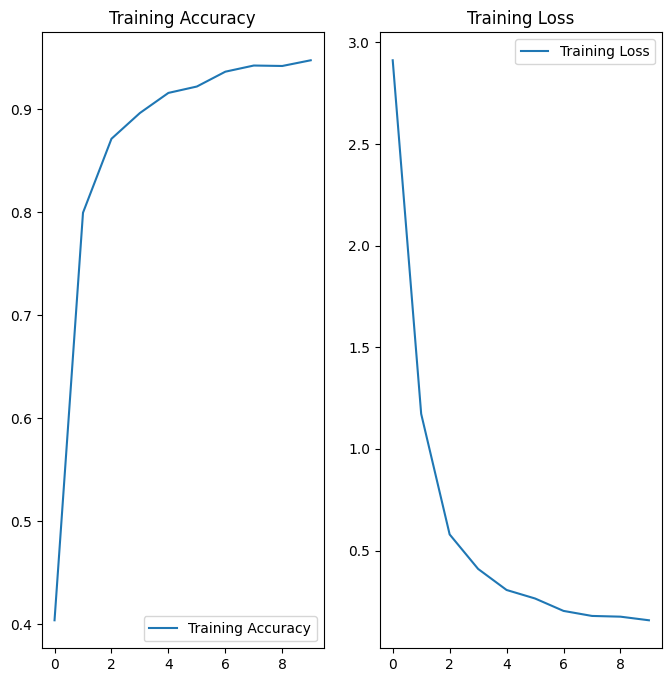

In [31]:
acc = history .history['sparse_categorical_accuracy']
loss = history.history['loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [36]:
scores = model.evaluate(test_ds)

W0000 00:00:1721254563.607171     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 145/1258 ━━━━━━━━━━━━━━━━━━━━ 5:03 273ms/step - loss: nan - sparse_categorical_accuracy: 0.5823

Invalid SOS parameters for sequential JPEG


 341/1258 ━━━━━━━━━━━━━━━━━━━━ 4:05 268ms/step - loss: nan - sparse_categorical_accuracy: 0.5838

Invalid SOS parameters for sequential JPEG


 485/1258 ━━━━━━━━━━━━━━━━━━━━ 3:26 267ms/step - loss: nan - sparse_categorical_accuracy: 0.5844

Invalid SOS parameters for sequential JPEG


 595/1258 ━━━━━━━━━━━━━━━━━━━━ 2:57 267ms/step - loss: nan - sparse_categorical_accuracy: 0.5842

Invalid SOS parameters for sequential JPEG


 629/1258 ━━━━━━━━━━━━━━━━━━━━ 2:47 267ms/step - loss: nan - sparse_categorical_accuracy: 0.5841

Invalid SOS parameters for sequential JPEG


 818/1258 ━━━━━━━━━━━━━━━━━━━━ 1:57 266ms/step - loss: nan - sparse_categorical_accuracy: 0.5841

Invalid SOS parameters for sequential JPEG


1054/1258 ━━━━━━━━━━━━━━━━━━━━ 54s 266ms/step - loss: nan - sparse_categorical_accuracy: 0.5840

Invalid SOS parameters for sequential JPEG


1258/1258 ━━━━━━━━━━━━━━━━━━━━ 391s 297ms/step - loss: nan - sparse_categorical_accuracy: 0.5843


W0000 00:00:1721254936.758081     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


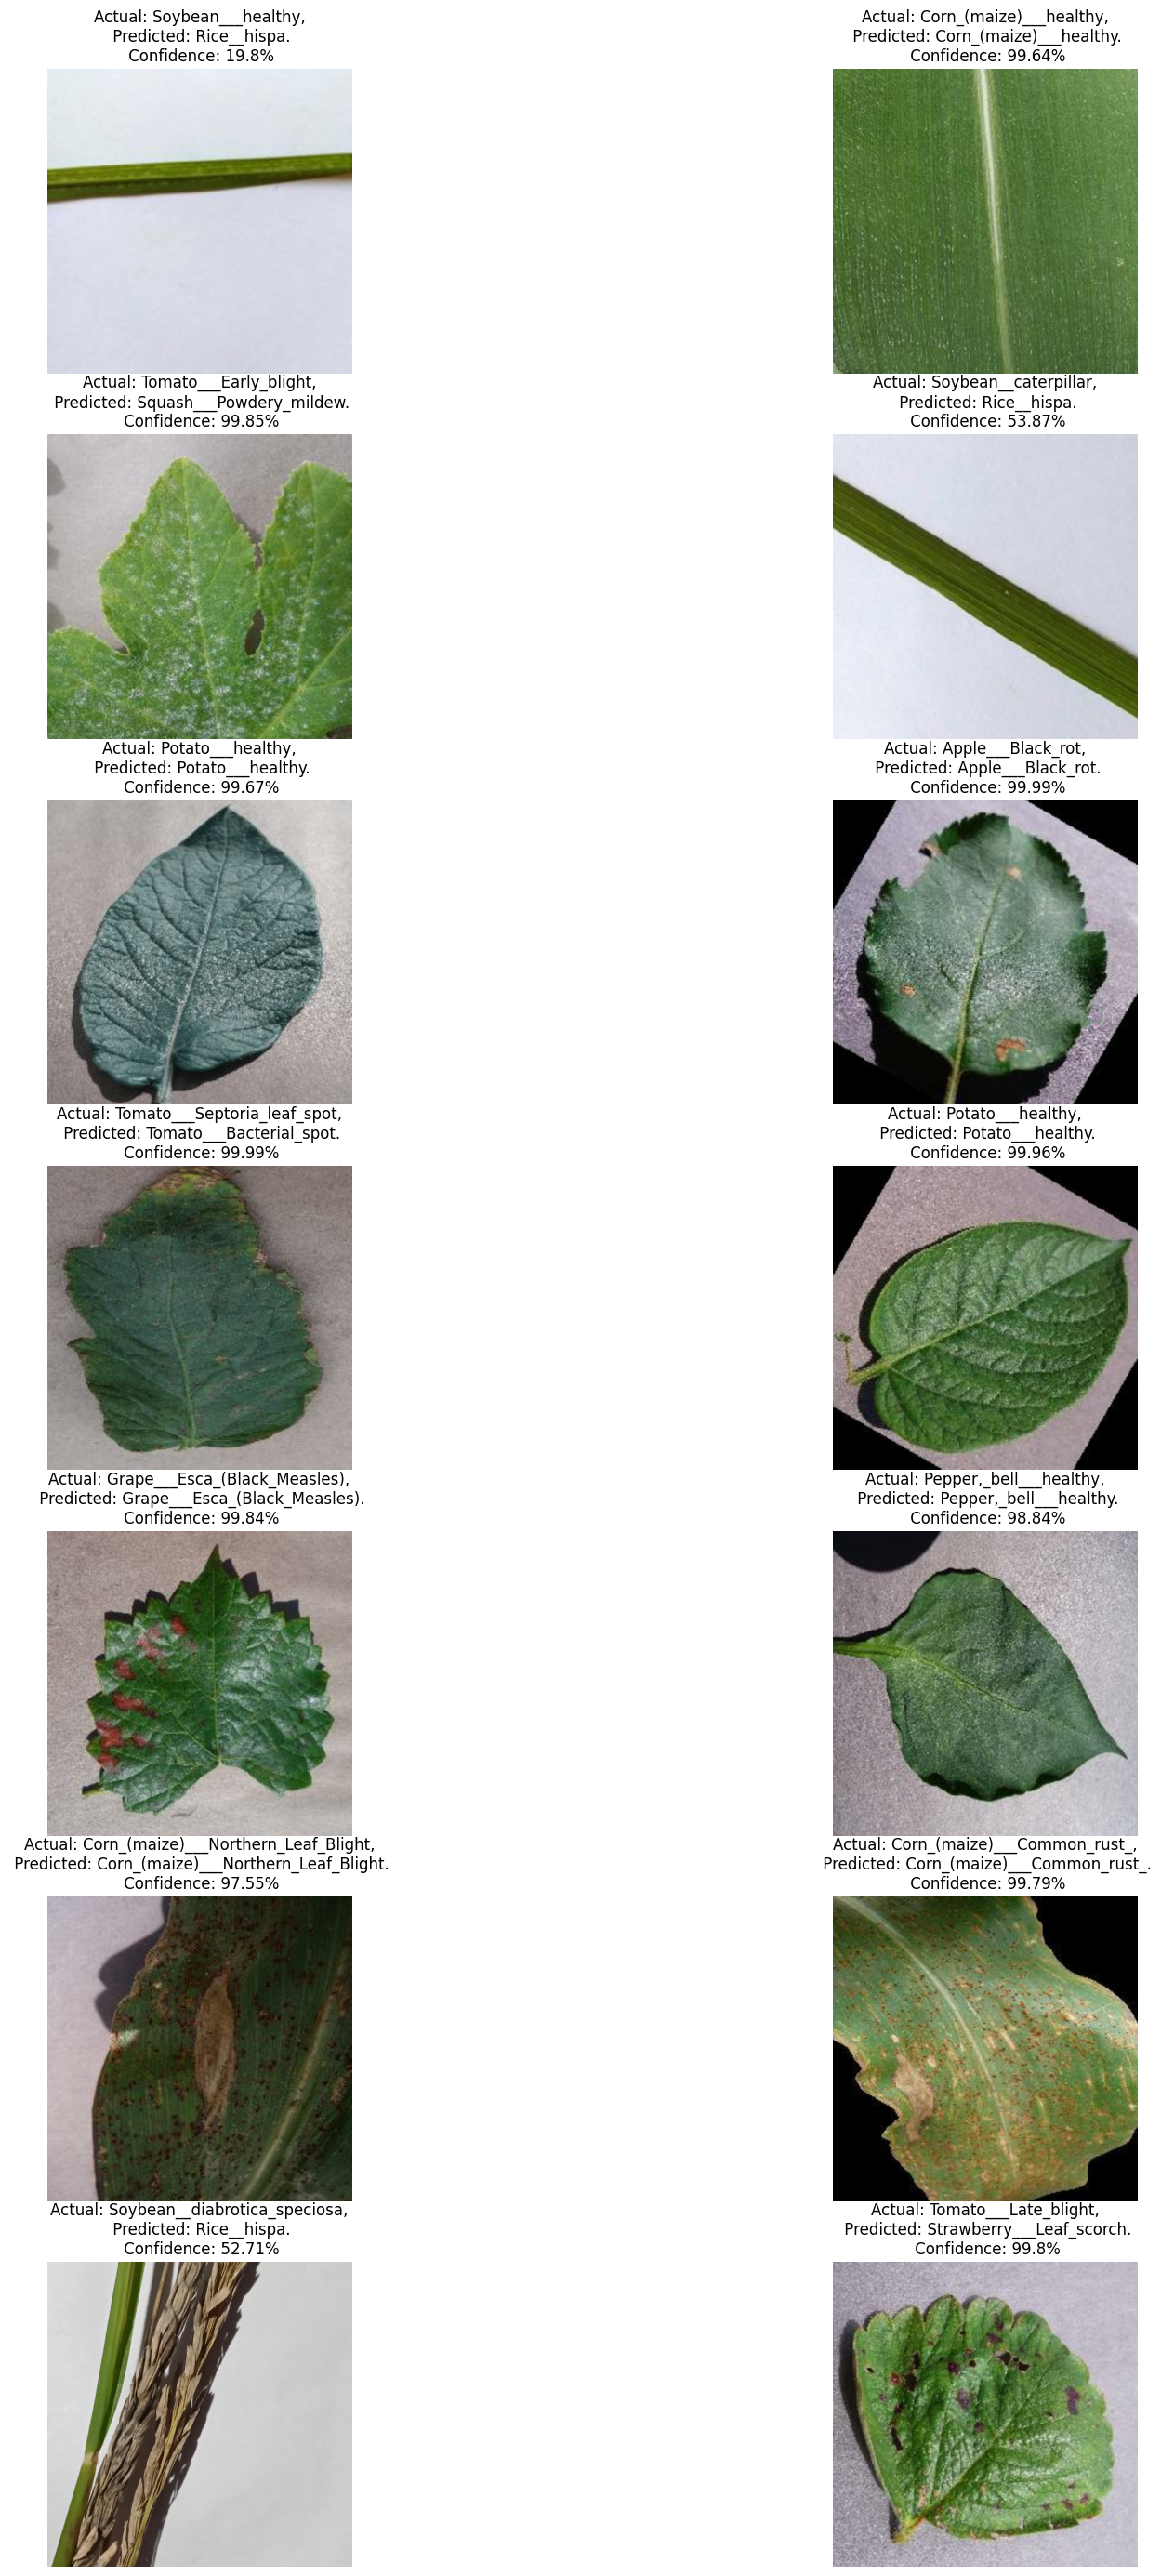

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
plt.figure(figsize=(20, 40))
for images, labels in test_ds.take(1):
    for i in range(14):
        ax = plt.subplot(8, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")